## Notebook Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms # It provides utilities for working with image data
from torch.distributions import Normal, kl_divergence
import matplotlib.pyplot as plt
import numpy as np
import random

### Setup device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Convolutional Neural Network

![Animation](https://miro.medium.com/v2/resize:fit:720/format:webp/1*fXxDBsJ96FKEtMOa9vNgjA.gif)


![Description or Title of Image](https://drive.google.com/uc?export=view&id=1mqhBcWGbRI2rEttnv2t-y9NLYasaD5pI)


### Define Bayesian Layers and Network

In [3]:
class BayesianConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(BayesianConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        # Parameters registration for the mean and the standard deviation of the weights
        self.weight_mu = nn.Parameter(torch.Tensor(out_channels, in_channels, kernel_size, kernel_size))
        self.weight_rho = nn.Parameter(torch.Tensor(out_channels, in_channels, kernel_size, kernel_size))
        self.bias_mu = nn.Parameter(torch.Tensor(out_channels))
        self.bias_rho = nn.Parameter(torch.Tensor(out_channels))

        # Initialize parameters
        self.reset_parameters() #--- initializes the parameters of the BayesianConv2d layer.

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight_mu, mode='fan_out', nonlinearity='relu') #--- Kaiming Initialization is an initialization method for NN that takes into account the non-linearity of activation functions.
        nn.init.constant_(self.weight_rho, -3)
        nn.init.constant_(self.bias_mu, 0)
        nn.init.constant_(self.bias_rho, -3)

    #---- The function torch.exp() computes the exponential of the input, which grows very fast. Therefore, initializing weight_rho and bias_rho with negative values helps to start with a smaller standard deviation.

    def forward(self, input):
        # Calculate the standard deviation from rho parameter
        weight_sigma = torch.log1p(torch.exp(self.weight_rho)) # torch.log1p function in PyTorch is used to compute the natural logarithm of one plus the input value, useful when argument is small
        bias_sigma = torch.log1p(torch.exp(self.bias_rho))

        # Sample weights and biases from the normal distributions defined by mu and sigma
        weight = Normal(self.weight_mu, weight_sigma).rsample() #--- reparameterized sample, allowing gradients to flow through the random sampling process
        bias = Normal(self.bias_mu, bias_sigma).rsample()
        #---- see reparametrization trick

        # Perform the convolution
        return nn.functional.conv2d(input, weight, bias, self.stride, self.padding)
        #--- the sampled weights and biases are used to perform a convolution operation on the input.

    def kl_loss(self):
        # Calculate the KL divergence loss for each layer
        weight_prior = Normal(0, 1)
        bias_prior = Normal(0, 1)
        weight_post = Normal(self.weight_mu, torch.log1p(torch.exp(self.weight_rho)))
        bias_post = Normal(self.bias_mu, torch.log1p(torch.exp(self.bias_rho)))
        return kl_divergence(weight_post, weight_prior).sum() + kl_divergence(bias_post, bias_prior).sum()



> In Bayesian neural networks, parameters are not fixed but are assumed to be drawn from probability distributions. The KL divergence helps in regularizing these distributions during training by measuring how much the learned distributions (posterior distributions) of the model parameters deviate from prior distributions.

> By minimizing the KL divergence, you effectively encourage the posterior distributions of the weights and biases to be close to the prior distributions. This is important because it incorporates a Bayesian update of beliefs about model parameters, balancing the fit to the data against the complexity of the model.

> Including the KL divergence in the training loss allows the network to balance between fitting the complex patterns in the data (learning from the data) and maintaining a simpler, more general model (sticking close to the prior). This helps in preventing overfitting, especially when dealing with limited data.

> Minimizing the KL divergence in the context of Bayesian inference is akin to maximizing the posterior probability of the model parameters given the data, under the constraints set by the prior. This adds a probabilistic interpretation to the learning process, providing not just point estimates but distributions over possible values of parameters. KL-loss integrates prior knowledge.




In [4]:
class BayesianCNN(nn.Module):
    def __init__(self):
        super(BayesianCNN, self).__init__()
        self.conv1 = BayesianConv2d(1, 20, kernel_size=5, stride=1, padding=2)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = BayesianConv2d(20, 50, kernel_size=5, stride=1, padding=2)
        self.fc1 = nn.Linear(50 * 7 * 7, 500) #---- fc: fully connected
        self.fc2 = nn.Linear(500, 10)
        # Given that the pooling layers reduce the dimensions of the feature maps and the original size
        # of the MNIST images is 28x28, after two pooling operations with a stride of 2
        # and padding that maintains the dimension post-convolution, the dimension is reduced to 28/2/2 = 7

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        return self.fc2(x)

    def kl_loss(self):
        # Aggregate KL divergence losses from all Bayesian layers
        return self.conv1.kl_loss() + self.conv2.kl_loss()


### Data Preparation

Load and prepare the MNIST dataset for training and testing.



In [5]:
# Transformations applied on each image
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Loading MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 9912422/9912422 [00:00<00:00, 17896744.01it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 404511.07it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 1648877/1648877 [00:00<00:00, 4389233.51it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 4542/4542 [00:00<00:00, 3075642.36it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### Training and Testing

In [6]:
def train(model, optimizer, criterion, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad() # Clears old gradients from the last step (otherwise gradients would be accumulated to existing gradients from previous steps).
            output = model(images)
            kl = model.kl_loss()
            loss = criterion(output, labels) + kl / len(train_dataset)
            loss.backward() # Computes the gradient of the loss function with respect to the network weights
            optimizer.step() # Updates the weights of the network based on the gradients computed during loss.backward
            total_loss += loss.item() # extract scalar value
        print(f'Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}')


In [7]:
def test(model, mc_samples=10):
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = torch.stack([model(images) for _ in range(mc_samples)])
            mean_outputs = outputs.mean(0)
            pred = mean_outputs.max(1, keepdim=True)[1]
            correct += pred.eq(labels.view_as(pred)).sum().item()
            total += labels.size(0)

    return correct, total, outputs, labels

In [8]:
model = BayesianCNN().to(device)


In [9]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Train the model
train(model, optimizer, criterion, epochs=5)

Epoch 1, Loss: 1.2622963481112075
Epoch 2, Loss: 1.037250235772082
Epoch 3, Loss: 0.9404514991779571
Epoch 4, Loss: 0.8518502628371152
Epoch 5, Loss: 0.7715727636681945


### Analysis of Performance

In [10]:
# Test the model and estimate uncertainty
correct, total, outputs, labels = test(model,25)

print(f'Accuracy: {100. * correct / total}%')

Accuracy: 99.13%


In [11]:
print(np.shape(outputs))
print(np.shape(labels))

torch.Size([25, 16, 10])
torch.Size([16])


### Analysis

In [12]:
def display_image(image, label):
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f'Actual Label: {label}')
    plt.show()

In [13]:
def predict_and_estimate_uncertainty(model, image, mc_samples=25):
    model.eval()
    with torch.no_grad():
        outputs = torch.stack([model(image) for _ in range(mc_samples)])  # [mc_samples, 1, 10]
        print(np.shape(outputs))
        probabilities = torch.nn.functional.softmax(outputs, dim=2)
        mean_probabilities = torch.mean(probabilities, dim=0)
        std_probabilities = torch.std(probabilities, dim=0)

        pred_label = mean_probabilities.argmax(dim=1).item()
        max_prob = mean_probabilities.max(dim=1)[0].item()
        uncertainty = std_probabilities.mean().item()

    return pred_label, max_prob, uncertainty

In [14]:
# Randomly select an image from the test dataset
random_idx = random.randint(0, len(test_dataset) - 1)
image, label = test_dataset[random_idx]
image = image.unsqueeze(0).to(device)  # Add batch dimension and send to device


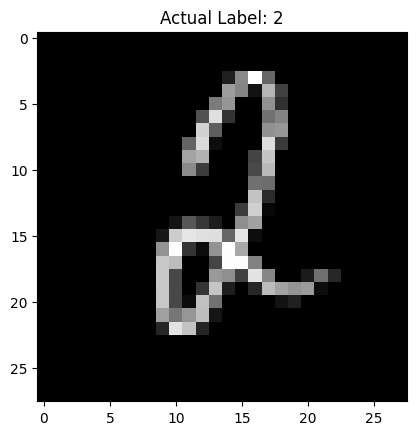

In [15]:
# Display the image
display_image(image.cpu().squeeze(), label)

In [16]:
# Predict and estimate uncertainty
predicted_label, probability, uncertainty = predict_and_estimate_uncertainty(model, image, mc_samples=25)


torch.Size([25, 1, 10])


In [17]:
print(f"Predicted Label: {predicted_label}")
print(f"Probability of Prediction: {probability:.4f}")
print(f"Uncertainty of Prediction: {uncertainty:.4f}")

Predicted Label: 2
Probability of Prediction: 0.9819
Uncertainty of Prediction: 0.0048


In [18]:
#------ Let's rotate the image

In [19]:
from torchvision import transforms

# Define a rotation transformation
rotation_transform = transforms.RandomRotation(degrees=(-180, 180))

def display_and_predict_with_rot(model, test_dataset, random_idx, mc_samples=10):
    # Randomly select an image from the test dataset
    #random_idx = random.randint(0, len(test_dataset) - 1)
    image, label = test_dataset[random_idx]

    # Convert to PIL Image to apply rotation, then convert back to tensor
    pil_image = transforms.ToPILImage()(image)
    rotated_image = rotation_transform(pil_image)
    image = transforms.ToTensor()(rotated_image).unsqueeze(0).to(device)  # Add batch dimension and send to device

    # Display the rotated image
    display_image(image.cpu().squeeze(), label)

    # Predict and estimate uncertainty
    predicted_label, probability, uncertainty = predict_and_estimate_uncertainty(model, image, mc_samples=mc_samples)

    print(f"Predicted Label: {predicted_label}")
    print(f"Probability of Prediction: {probability:.4f}")
    print(f"Uncertainty of Prediction: {uncertainty:.4f}")


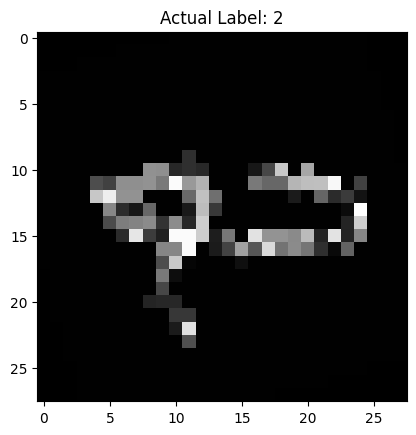

torch.Size([50, 1, 10])
Predicted Label: 7
Probability of Prediction: 0.7036
Uncertainty of Prediction: 0.0295


In [20]:
# Call the function
display_and_predict_with_rot(model, test_dataset, random_idx, mc_samples=50)

In [21]:
#-------- adding noise

In [22]:
def add_gaussian_noise(image, mean=0., std=0.5):
    """Add Gaussian noise to an image."""
    noise = torch.randn(image.size()) * std + mean
    noisy_image = image + noise
    return torch.clamp(noisy_image, 0., 1.)  # Clamp to ensure the pixel values are valid

def display_and_predict_with_noise(model, test_dataset, random_idx, mc_samples=10):
    # Randomly select an image from the test dataset
    #random_idx = random.randint(0, len(test_dataset) - 1)
    image, label = test_dataset[random_idx]

    # Add Gaussian noise to the image
    noisy_image = add_gaussian_noise(image).unsqueeze(0).to(device)  # Add batch dimension and send to device

    # Display the noisy image
    display_image(noisy_image.cpu().squeeze(), label)

    # Predict and estimate uncertainty
    predicted_label, probability, uncertainty = predict_and_estimate_uncertainty(model, noisy_image, mc_samples=mc_samples)

    print(f"Predicted Label: {predicted_label}")
    print(f"Probability of Prediction: {probability:.4f}")
    print(f"Uncertainty of Prediction: {uncertainty:.4f}")



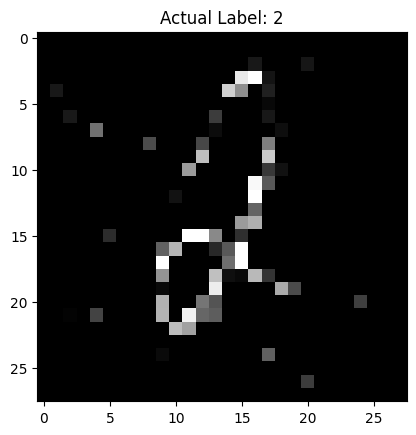

torch.Size([50, 1, 10])
Predicted Label: 2
Probability of Prediction: 0.2929
Uncertainty of Prediction: 0.0280


In [23]:
# Call the function
display_and_predict_with_noise(model, test_dataset, random_idx, mc_samples=50)

### Additional Comments

Let’s clarify and make sure the network architecture and Bayesian aspect are correctly implemented and understood. I provided a framework that defines Bayesian convolutional layers where each weight in these layers is represented by a distribution rather than a fixed value. This is a fundamental aspect of Bayesian neural networks, which use probability distributions over parameters rather than point estimates. However, I might have oversimplified some explanations or skipped over details. Here’s a more detailed explanation and verification:

Is it Convolutional?
A convolutional neural network (CNN) primarily consists of convolutional layers that perform convolution operations. The code snippets I provided earlier define a BayesianConv2d class meant to replace the standard convolutional layer (nn.Conv2d) in PyTorch. This custom layer maintains the convolutional aspect by performing convolutions within the forward method:




```
return nn.functional.conv2d(input, weight, bias, self.stride, self.padding)
```


Here, weight and bias are sampled from their respective distributions, making each forward pass different and stochastic, reflecting the Bayesian inference principle. The presence of convolution operations indeed confirms that it’s a convolutional neural network.

**Is it Bayesian?**
The Bayesian aspect comes from treating the parameters (weights and biases) of the neural network as random variables instead of fixed numbers. In a traditional neural network, weights are learned and fixed after training. In contrast, a Bayesian neural network maintains a distribution over these weights, which reflects uncertainty about the model parameters. This approach was implemented in the BayesianConv2d class, where weights and biases are defined by normal distributions with parameters mu (mean) and rho (a parameter from which standard deviation is derived):

```
weight = Normal(self.weight_mu, weight_sigma).rsample()
bias = Normal(self.bias_mu, bias_sigma).rsample()
```

These distributions are sampled during each forward pass, making the output dependent on these stochastic parameters, which is a key feature of Bayesian inference.

**Bayesian Inference Through ELBO**
The true Bayesian nature is also evident from the use of the Evidence Lower Bound (ELBO), which was discussed in relation to the model’s training objective. The loss function combines the likelihood of the data (how well the model predicts the data) with the KL divergence between the approximate posterior (parameters of the distributions after training) and the prior distributions:

```
loss = criterion(output, labels) + kl / len(train_dataset)
```

This loss function includes the KL divergence term, which penalizes the model if the variational distribution strays too far from the prior, a key aspect of Bayesian variational inference.

**Summary**
The network is both convolutional, due to the use of convolution operations in the layers, and Bayesian, due to the probabilistic treatment of the parameters and the optimization of ELBO. This setup allows it to not only learn from data but also incorporate uncertainty in its predictions, which can be crucial for applications where decision-making under uncertainty is critical.

### Applications in Medical Imaging

Diabetic retinopathy is the leading cause of blindness in the working-age population of the developed world. It is estimated to affect over 93 million people.

![Image](https://storage.googleapis.com/kaggle-media/competitions/kaggle/4104/media/retina.jpg)


https://www.kaggle.com/c/diabetic-retinopathy-detection/overview


The US Center for Disease Control and Prevention estimates that 29.1 million people in the US have diabetes and the World Health Organization estimates that 347 million people have the disease worldwide. Diabetic Retinopathy (DR) is an eye disease associated with long-standing diabetes. Around 40% to 45% of Americans with diabetes have some stage of the disease. Progression to vision impairment can be slowed or averted if DR is detected in time, however this can be difficult as the disease often shows few symptoms until it is too late to provide effective treatment.